In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from scipy.special import boxcox1p, inv_boxcox1p

import sklearn
from sklearn import metrics,preprocessing,svm
from sklearn.linear_model import ElasticNetCV, RidgeCV, LassoCV
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

import xgboost as xgb
from mlxtend.regressor import StackingCVRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option("display.max_rows", None, "display.max_columns", None)

### Load train and test dataframe and investigate the different datatypes

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Splitting the train/test dataframes into a dataframe containing the categorical variables and numerical variables:

In [4]:
numerical_columns = [column for column in df_train.columns if df_train[column].dtype in ["int64" , "float64"]]
numerical_df = df_train[numerical_columns].drop(columns="Id")
numerical_df.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500


In [5]:
# test dataset:
test_Id = df_test["Id"]
numerical_columns_test = [column for column in df_test.columns if df_test[column].dtype in ["int64" , "float64"]]
numerical_df_test = df_test[numerical_columns_test].drop(columns="Id")
numerical_df_test.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,6,2010
2,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,1997.0,2.0,482.0,212,34,0,0,0,0,0,3,2010


In [6]:
categorical_df = df_train.drop(columns=numerical_columns)
categorical_df_test = df_test.drop(columns=numerical_columns_test)
categorical_df_test.head(3)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RH,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,Rec,LwQ,GasA,TA,Y,SBrkr,TA,Typ,NaN,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,NaN,Attchd,Unf,TA,TA,Y,NaN,NaN,Gar2,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Gd,Y,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal


In [7]:
# Show the percentage of missing values per column:
def percentage_nan(df):
    percentage_nan = df.isna().sum() / len(df) * 100
    percentage_nan_df = pd.DataFrame({"columns": df.columns, "Percentage_NaN": percentage_nan})
    percentage_nan_df.sort_values("Percentage_NaN", ascending=False, inplace=True)
    percentage_nan_above0 = percentage_nan_df[percentage_nan_df["Percentage_NaN"] > 0]
    return percentage_nan_above0


## categorical data:

###  Adding the SalePrice column to the categorical df to investigate the correlation of these variables to the SalePrice:


In [8]:
categorical_df["SalePrice"] = df_train["SalePrice"].copy()

In [9]:
percentage_nan(categorical_df)

,columns,Percentage_NaN
PoolQC,PoolQC,99.520548
MiscFeature,MiscFeature,96.301370
Alley,Alley,93.767123
Fence,Fence,80.753425
FireplaceQu,FireplaceQu,47.260274
GarageType,GarageType,5.547945
GarageQual,GarageQual,5.547945
GarageFinish,GarageFinish,5.547945
GarageCond,GarageCond,5.547945
BsmtFinType2,BsmtFinType2,2.602740


### Replace the missing values with the most common value, SBrkr for electrical (standard circuit breaker) or NA if there is no basement, garage, pool etc.

In [10]:
cleaned_categorical_df = categorical_df.copy()
# Train df:
train_categorical_nan_dic = {
                            "GarageCond": "NA",
                            "GarageQual": "NA",
                            "GarageFinish": "NA",
                            "GarageType":"NA",
                            "BsmtQual": "NA",
                            "BsmtCond": "NA",
                            "MasVnrType": cleaned_categorical_df["MasVnrType"].mode()[0],
                            "BsmtExposure": "NA",
                            "BsmtFinType2": "NA",
                            "BsmtFinType1": "NA",
                            "Electrical": "SBrkr",
                            "PoolQC": "NA",
                            "MiscFeature": "NA",
                            "Alley": "NA",
                            "Fence": "NA",
                            "FireplaceQu": "NA",                                        
}

cleaned_categorical_df = cleaned_categorical_df.fillna(train_categorical_nan_dic)
percentage_nan(cleaned_categorical_df)

,columns,Percentage_NaN


In [11]:
percentage_nan(categorical_df_test)

,columns,Percentage_NaN
PoolQC,PoolQC,99.794380
MiscFeature,MiscFeature,96.504455
Alley,Alley,92.666210
Fence,Fence,80.123372
FireplaceQu,FireplaceQu,50.034270
GarageCond,GarageCond,5.346127
GarageQual,GarageQual,5.346127
GarageFinish,GarageFinish,5.346127
GarageType,GarageType,5.209047
BsmtCond,BsmtCond,3.084304


In [12]:
# test df:
cleaned_categorical_df_test = categorical_df_test.copy()
test_categorical_nan_dic = {    
                            "GarageCond": "NA",
                            "GarageQual": "NA",
                            "GarageFinish": "NA",
                            "GarageType": "NA",
                            "BsmtCond": "NA",
                            "BsmtQual": "NA",
                            "MasVnrType": cleaned_categorical_df_test["MasVnrType"].mode()[0],
                            "MSZoning": cleaned_categorical_df_test["MSZoning"].mode()[0],
                            "KitchenQual": "TA",
                            "SaleType": cleaned_categorical_df_test["SaleType"].mode()[0],
                            "BsmtExposure": "NA",
                            "BsmtFinType2": "NA",
                            "BsmtFinType1": "NA",
                            "Electrical": "SBrkr",
                            "Utilities": "AllPub",
                            "Functional": "Typ",
                            "Exterior2nd": cleaned_categorical_df_test["Exterior2nd"].mode()[0],
                            "Exterior1st": cleaned_categorical_df_test["Exterior1st"].mode()[0],
                            "PoolQC": "NA",
                            "MiscFeature": "NA",
                            "Alley": "NA",
                            "Fence": "NA",
                            "FireplaceQu": "NA",
}
cleaned_categorical_df_test = cleaned_categorical_df_test.fillna(test_categorical_nan_dic)
percentage_nan(cleaned_categorical_df_test)

,columns,Percentage_NaN


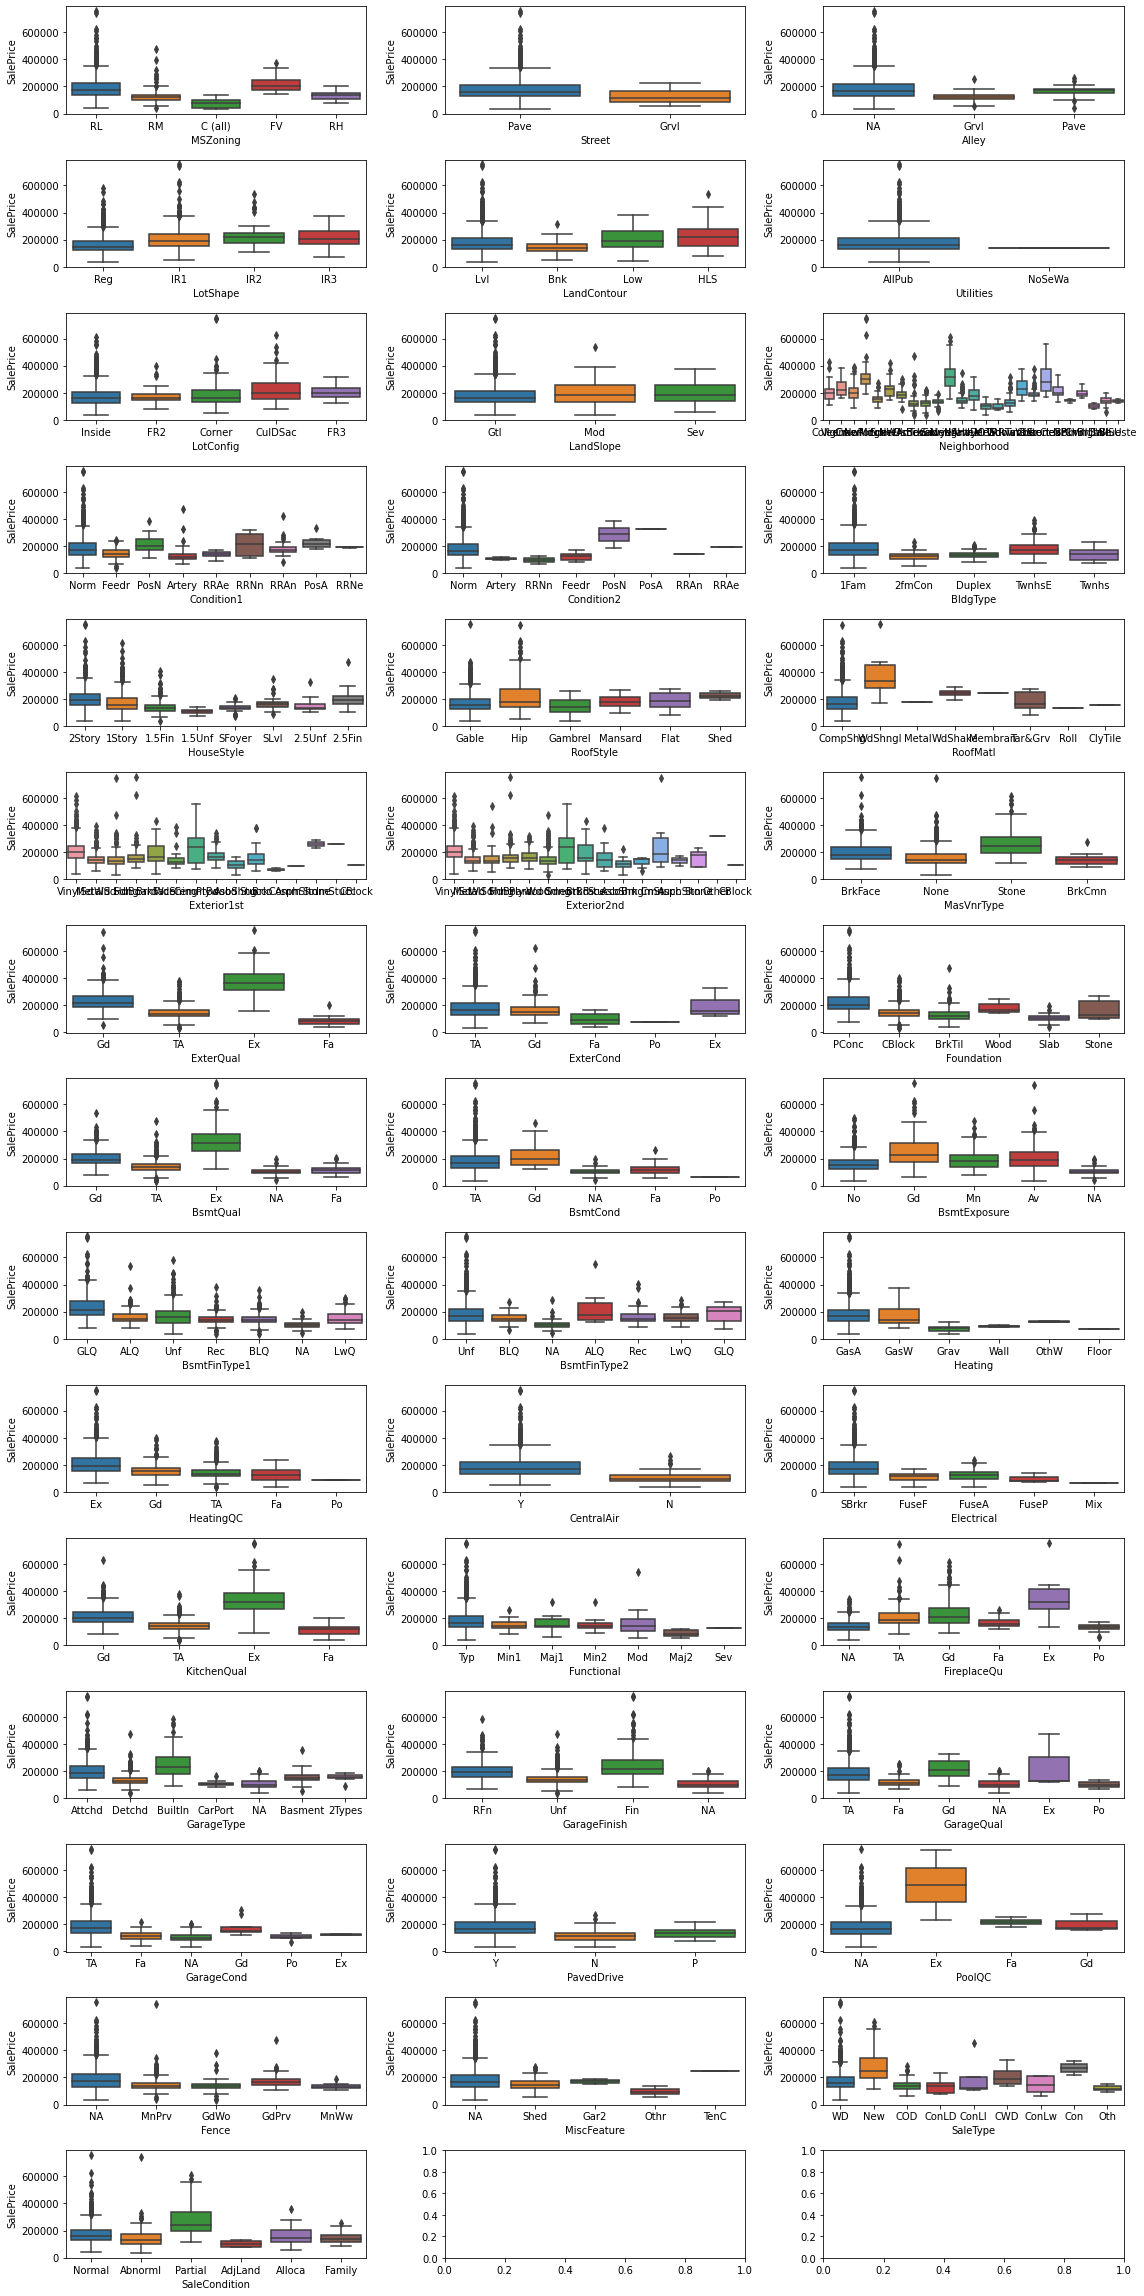

In [13]:
fig, axes = plt.subplots(round(len(cleaned_categorical_df.columns)/3), 3, figsize=(16,32))
for i, ax in enumerate(fig.axes):
    if i < len(cleaned_categorical_df.columns) - 1:
        sns.boxplot(ax=ax,x=cleaned_categorical_df.columns[i], y="SalePrice", data=cleaned_categorical_df)
fig.tight_layout() 

### Selecting ordinal variables that can be ordinal encoded. I excluded the basement and garage values, as not all houses have a basement and/or garage. Excluded variables with NA values as well.

In [14]:

ordinal_variables = [
                    "ExterQual", "ExterCond","PavedDrive",
                    "KitchenQual", "HeatingQC",                 
]

ordinal_columns = cleaned_categorical_df[ordinal_variables]
ordinal_columns_test = cleaned_categorical_df_test[ordinal_variables]
selected_categorical_df = cleaned_categorical_df.drop(columns = ordinal_variables)
selected_categorical_df_test = cleaned_categorical_df_test.drop(columns = ordinal_variables)

In [15]:
# Ordinal dictionaries:
PavedDrive_dic = {"Y":3, "P":2, "N":1}
quality_dic = {"Ex":5, "Gd":4, "TA": 3, "Fa":2, "Po":1, "NA":0}

In [16]:
# Make the ordinal and binary catergorical columns numeric and add them to the numerical dataframe:
for ordinal_variable in ordinal_variables:

    if ordinal_variable == "PavedDrive":
        numerical_df[ordinal_variable] = ordinal_columns[ordinal_variable].map(PavedDrive_dic)
        numerical_df_test[ordinal_variable] = ordinal_columns_test[ordinal_variable].map(PavedDrive_dic)
        
    else:
        numerical_df[ordinal_variable] = ordinal_columns[ordinal_variable].map(quality_dic)
        numerical_df_test[ordinal_variable] = ordinal_columns_test[ordinal_variable].map(quality_dic)
numerical_df.head(4)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,ExterQual,ExterCond,PavedDrive,KitchenQual,HeatingQC
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,4,3,3,4,5
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500,3,3,3,3,5
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500,4,3,3,4,5
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000,3,3,3,4,4


In [17]:
numerical_df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,ExterQual,ExterCond,PavedDrive,KitchenQual,HeatingQC
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.00000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890,3.39589,3.083562,2.856164,3.511644,4.145205
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883,0.57428,0.351054,0.496592,0.663760,0.959501
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,2.00000,1.000000,1.000000,2.000000,1.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000,3.00000,3.000000,3.000000,3.000000,3.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000,3.00000,3.000000,3.000000,3.000000,5.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000,4.00000,3.000000,3.000000,4.000000,5.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000,5.00000,5.000000,3.000000,5.000000,5.000000


### Changing numerical variables into categorical: As year sold (YrSold) from the numerical dataframe only ranges from 2006 to 2010 it will be made into a categorical variable. The same for MoSold (12 months) and MSSubClass, as MSSubClass identifies the type of dwelling involved in the sale.

In [18]:
selected_categorical_df["YrSold"] = numerical_df["YrSold"].apply(lambda x: str(x))
selected_categorical_df["MoSold"] = numerical_df["MoSold"].apply(lambda x: str(x))
selected_categorical_df["MSSubClass"] = numerical_df["MSSubClass"].apply(lambda x: str(x))

num_to_catg_list = ["YrSold", "MoSold", "MSSubClass"]
numerical_df = numerical_df.drop(columns=num_to_catg_list)

selected_categorical_df_test["YrSold"] = numerical_df_test["YrSold"].apply(lambda x: str(x))
selected_categorical_df_test["MoSold"] = numerical_df_test["MoSold"].apply(lambda x: str(x))
selected_categorical_df_test["MSSubClass"] = numerical_df_test["MSSubClass"].apply(lambda x: str(x))
numerical_df_test = numerical_df_test.drop(columns=num_to_catg_list)


<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

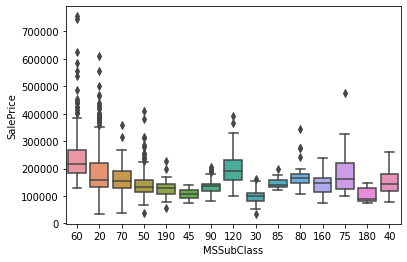

In [19]:
sns.boxplot(x=selected_categorical_df["MSSubClass"], y="SalePrice", data=selected_categorical_df)

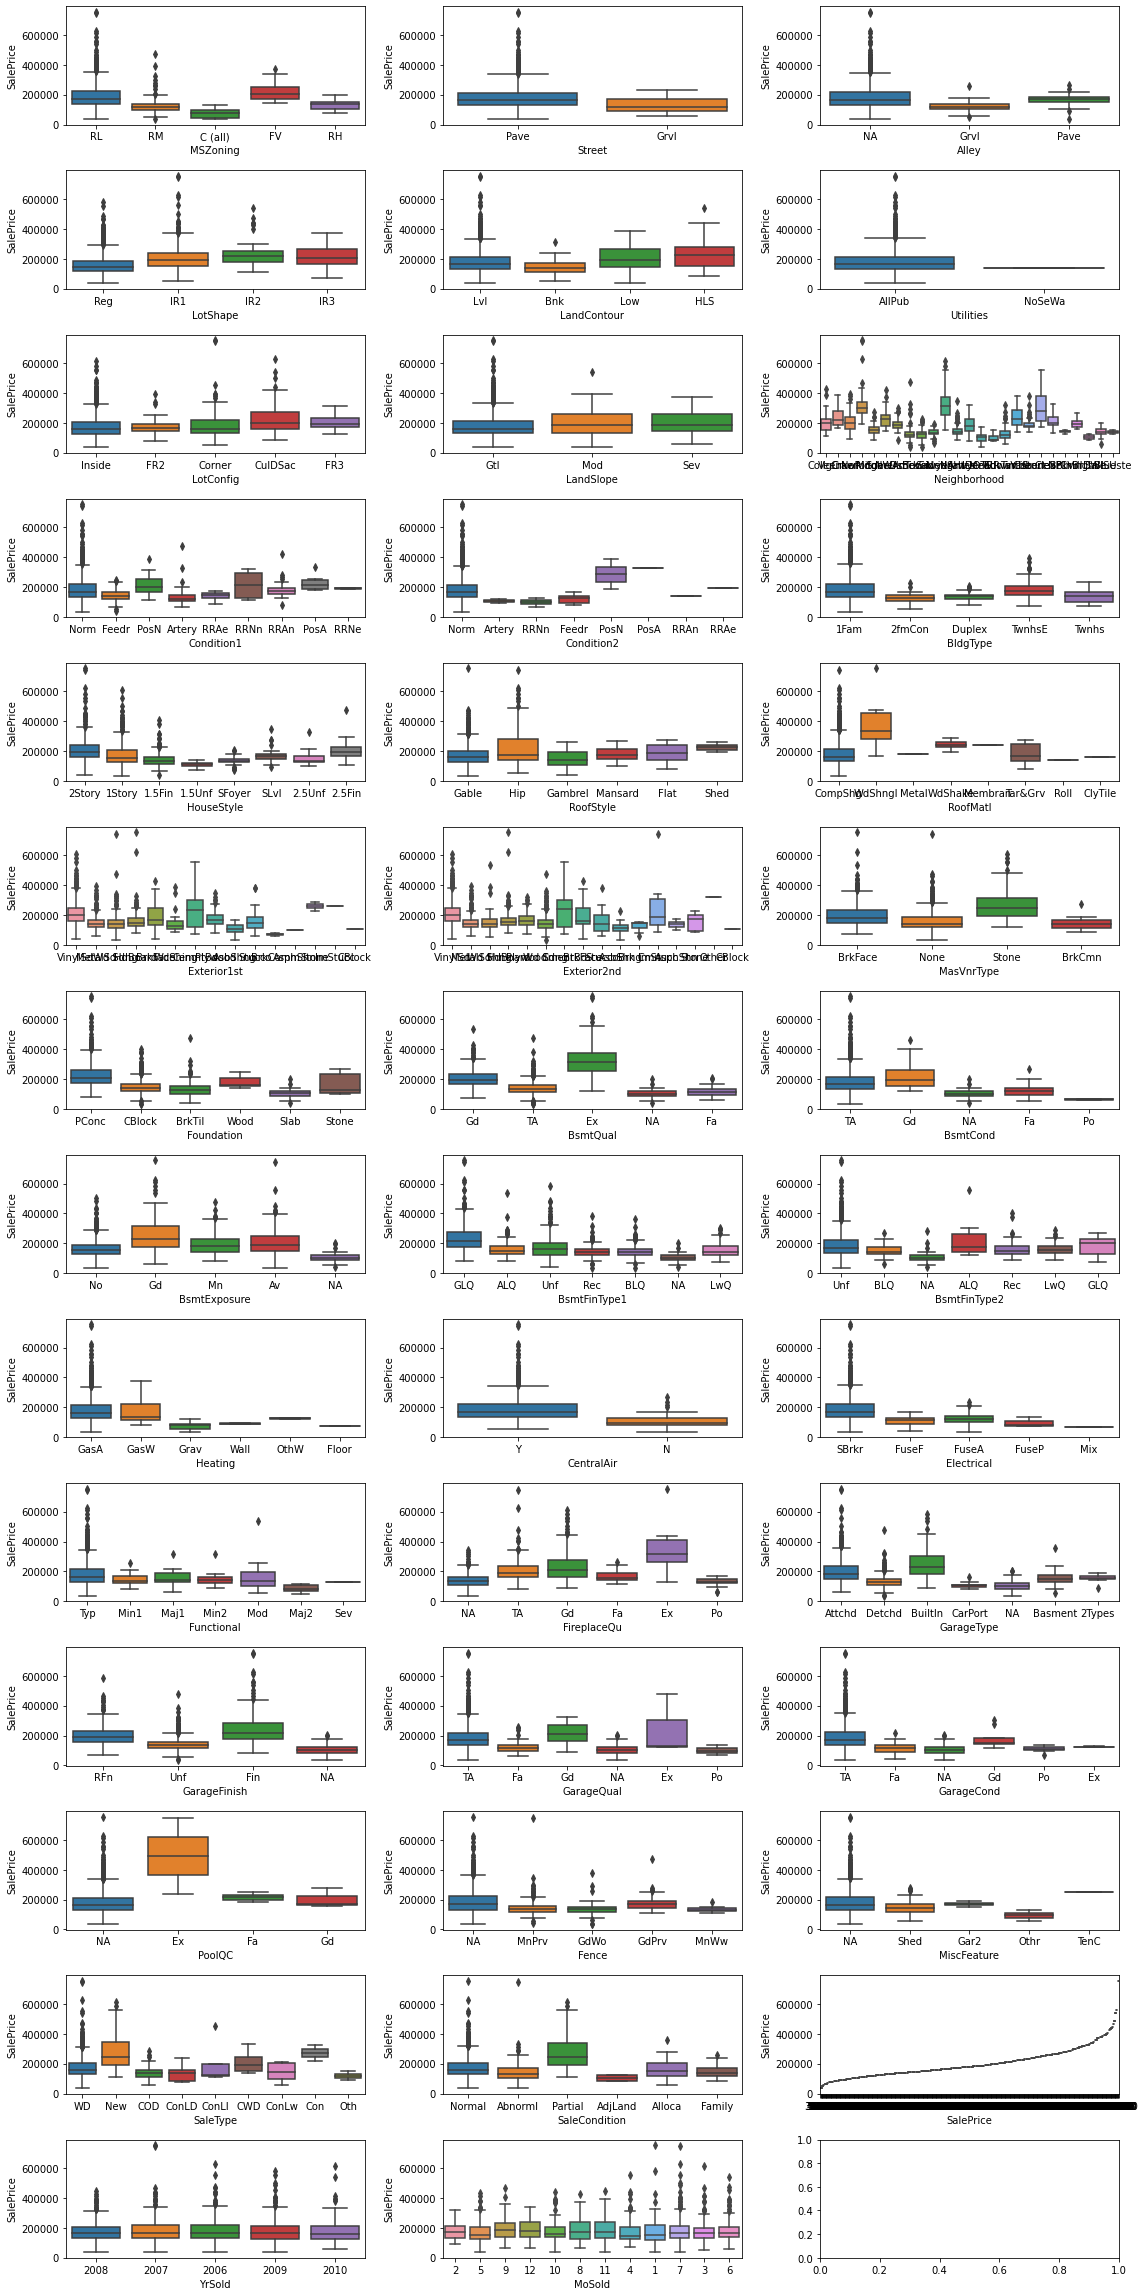

In [20]:
fig, axes = plt.subplots(round(len(selected_categorical_df.columns)/3), 3, figsize=(16,32))
for i, ax in enumerate(fig.axes):
    if i < len(selected_categorical_df.columns) - 1:
        sns.boxplot(ax=ax,x=selected_categorical_df.columns[i], y="SalePrice", data=selected_categorical_df)
fig.tight_layout() 

### From the boxplots above can be observed that some variables have a high variation between (some) groups, indicating a correlation with the SalePrice. Only these categorical variables are selected, as this increases the prediction of the model

In [21]:
corr_categorical_columns = ["MSZoning", "Neighborhood", "Condition1",
                                "Condition2", "BldgType", "HouseStyle", "RoofMatl",
                                "MasVnrType", "Foundation", "Heating", "CentralAir",
                                "FireplaceQu", "GarageType", "PoolQC", 
                                "SaleType", "SaleCondition", "MSSubClass",
                                "BsmtQual", "BsmtCond", "GarageFinish", "GarageQual", "GarageCond"
                            
                               ]
selected_categorical_df = selected_categorical_df[corr_categorical_columns]
selected_categorical_df_test = selected_categorical_df_test[corr_categorical_columns]

### Dummy encoding the selected categorical variables:

In [22]:
categorical_dummies = pd.get_dummies(selected_categorical_df)
categorical_dummies_test = pd.get_dummies(selected_categorical_df_test)
categorical_dummies.head(1)

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NA,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_NA,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NA,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_NA,BsmtCond_Po,BsmtCond_TA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA
0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1


### Some columns are in train dataset but not in the test dataset. These columns are therefore removed. The column that is in the test dataset but not in the train dataset is added to the train dataset with value 0.

In [23]:
print("in train not in test:")
dummies_not_in_test = [i for i in categorical_dummies.columns if i not in categorical_dummies_test.columns]
print(dummies_not_in_test)

print("\nin test not in train:")
dummies_not_in_train = [i for i in categorical_dummies_test.columns if i not in categorical_dummies.columns]
print(dummies_not_in_train)

in train not in test:
['Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_2.5Fin', 'RoofMatl_ClyTile', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'Heating_Floor', 'Heating_OthW', 'PoolQC_Fa', 'GarageQual_Ex']

in test not in train:
['MSSubClass_150']


In [24]:
categorical_dummies = categorical_dummies.drop(columns= dummies_not_in_test)
categorical_dummies[dummies_not_in_train] = 0

## Numerical variables:

In [25]:
numerical_df.head(3)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,ExterQual,ExterCond,PavedDrive,KitchenQual,HeatingQC
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,208500,4,3,3,4,5
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,181500,3,3,3,3,5
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,223500,4,3,3,4,5


In [26]:
numerical_df_test.head(3)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,ExterQual,ExterCond,PavedDrive,KitchenQual,HeatingQC
0,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,3,3,3,3,3
1,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,3,3,3,4,3
2,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,1997.0,2.0,482.0,212,34,0,0,0,0,0,3,3,3,3,4


In [27]:
# Show how many values are missing in the selected columns:
percentage_nan(numerical_df)

,columns,Percentage_NaN
LotFrontage,LotFrontage,17.739726
GarageYrBlt,GarageYrBlt,5.547945
MasVnrArea,MasVnrArea,0.547945


### Filling in the missing values. The missing values in the GarageYrBlt means there is no garage. However, replacing these values with 0 would mean a very old garage. I have therefore chosen to replace these values with the year of construction of the house itself.

In [28]:
train_numeric_nan_dic = {"MasVnrArea": numerical_df["MasVnrArea"].median(),
                         "LotFrontage": numerical_df["LotFrontage"].median(),
                         "GarageYrBlt":numerical_df["YearBuilt"],
}
cleaned_numerical_df = numerical_df.fillna(train_numeric_nan_dic)
percentage_nan(cleaned_numerical_df)

,columns,Percentage_NaN


In [29]:
percentage_nan(numerical_df_test)

,columns,Percentage_NaN
LotFrontage,LotFrontage,15.558602
GarageYrBlt,GarageYrBlt,5.346127
MasVnrArea,MasVnrArea,1.028101
BsmtHalfBath,BsmtHalfBath,0.137080
BsmtFullBath,BsmtFullBath,0.137080
BsmtUnfSF,BsmtUnfSF,0.068540
GarageArea,GarageArea,0.068540
TotalBsmtSF,TotalBsmtSF,0.068540
GarageCars,GarageCars,0.068540
BsmtFinSF2,BsmtFinSF2,0.068540


In [30]:
test_numeric_nan_dic = { 
                            "MasVnrArea": numerical_df_test["MasVnrArea"].median(),
                            "BsmtFullBath": int(0),
                            "BsmtHalfBath": int(0),
                            "GarageArea": int(0),
                            "GarageCars": int(0),
                            "BsmtFinSF1": int(0),
                            "BsmtFinSF2": int(0),
                            "BsmtUnfSF": int(0), 
                            "TotalBsmtSF": int(0),
                            "GarageYrBlt": numerical_df_test["YearBuilt"],
                            "LotFrontage": numerical_df_test["LotFrontage"].median(),                 
}
cleaned_numerical_df_test = numerical_df_test.fillna(test_numeric_nan_dic)
percentage_nan(cleaned_numerical_df_test)

,columns,Percentage_NaN


### Feature engineering; combining values into new variables:

In [31]:
cleaned_numerical_df["TotalSF"] = cleaned_numerical_df.apply(lambda x: int(x["1stFlrSF"]+x["2ndFlrSF"]+x["TotalBsmtSF"]), axis=1)
cleaned_numerical_df["TotalFinSF"] = cleaned_numerical_df.apply(lambda x: int(x["1stFlrSF"]+x["2ndFlrSF"]+
                                                                              x["BsmtFinSF1"]+x["BsmtFinSF2"]), axis=1)
cleaned_numerical_df["AllBath"] = cleaned_numerical_df.apply(lambda x: x["FullBath"]*1 + x["HalfBath"]*0.5 +
                                                                        x["BsmtFullBath"]*1 + x["BsmtHalfBath"]*0.5, axis=1)
cleaned_numerical_df["TotalPorchSF"] = cleaned_numerical_df.apply(lambda x: x["WoodDeckSF"]+x["OpenPorchSF"]+
                                                                            x["EnclosedPorch"]+x["3SsnPorch"]+
                                                                            x["ScreenPorch"], axis=1)
cleaned_numerical_df["SumBltRemod"] = cleaned_numerical_df.apply(lambda x: int(x["YearBuilt"]+x["YearRemodAdd"]), axis=1)

# Check if house components are present:
cleaned_numerical_df["PoolPresent"] = cleaned_numerical_df["PoolArea"].apply(lambda x: 1 if x > 0 else 0)
cleaned_numerical_df["2ndFlrPresent"] = cleaned_numerical_df["2ndFlrSF"].apply(lambda x: 1 if x > 0 else 0)
cleaned_numerical_df["GaragePresent"] = cleaned_numerical_df["GarageArea"].apply(lambda x: 1 if x > 0 else 0)
cleaned_numerical_df["BsmtPresent"] = cleaned_numerical_df["TotalBsmtSF"].apply(lambda x: 1 if x > 0 else 0)
cleaned_numerical_df["FireplacePresent"] = cleaned_numerical_df["Fireplaces"].apply(lambda x: 1 if x > 0 else 0)


In [32]:
# same for the test dataframe:
cleaned_numerical_df_test["TotalSF"] = cleaned_numerical_df_test.apply(lambda x: int(x["1stFlrSF"]+x["2ndFlrSF"]+x["TotalBsmtSF"]), axis=1)
cleaned_numerical_df_test["TotalFinSF"] = cleaned_numerical_df_test.apply(lambda x: int(x["1stFlrSF"]+x["2ndFlrSF"]+
                                                                              x["BsmtFinSF1"]+x["BsmtFinSF2"]), axis=1)
cleaned_numerical_df_test["AllBath"] = cleaned_numerical_df_test.apply(lambda x: x["FullBath"]*1 + x["HalfBath"]*0.5 +
                                                                            x["BsmtFullBath"]*1 + x["BsmtHalfBath"]*0.5, axis=1)
cleaned_numerical_df_test["TotalPorchSF"] = cleaned_numerical_df_test.apply(lambda x: x["WoodDeckSF"]+x["OpenPorchSF"]+
                                                                            x["EnclosedPorch"]+x["3SsnPorch"]+
                                                                            x["ScreenPorch"], axis=1)
cleaned_numerical_df_test["SumBltRemod"] = cleaned_numerical_df_test.apply(lambda x: int(x["YearBuilt"]+x["YearRemodAdd"]), axis=1)

cleaned_numerical_df_test["PoolPresent"] = cleaned_numerical_df_test["PoolArea"].apply(lambda x: 1 if x > 0 else 0)
cleaned_numerical_df_test["2ndFlrPresent"] = cleaned_numerical_df_test["2ndFlrSF"].apply(lambda x: 1 if x > 0 else 0)
cleaned_numerical_df_test["GaragePresent"] = cleaned_numerical_df_test["GarageArea"].apply(lambda x: 1 if x > 0 else 0)
cleaned_numerical_df_test["BsmtPresent"] = cleaned_numerical_df_test["TotalBsmtSF"].apply(lambda x: 1 if x > 0 else 0)
cleaned_numerical_df_test["FireplacePresent"] = cleaned_numerical_df_test["Fireplaces"].apply(lambda x: 1 if x > 0 else 0)
cleaned_numerical_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,ExterQual,ExterCond,PavedDrive,KitchenQual,HeatingQC,TotalSF,TotalFinSF,AllBath,TotalPorchSF,SumBltRemod,PoolPresent,2ndFlrPresent,GaragePresent,BsmtPresent,FireplacePresent
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,208500,4,3,3,4,5,2566,2416,3.5,61.0,4006,0,1,1,1,0
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,181500,3,3,3,3,5,2524,2240,2.5,298.0,3952,0,0,1,1,1
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,223500,4,3,3,4,5,2706,2272,3.5,42.0,4003,0,1,1,1,1
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,140000,3,3,3,4,4,2473,1933,2.0,307.0,3885,0,1,1,1,1
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,250000,4,3,3,4,5,3343,2853,3.5,276.0,4000,0,1,1,1,1


## Investigating the skewness of the numerical variables:

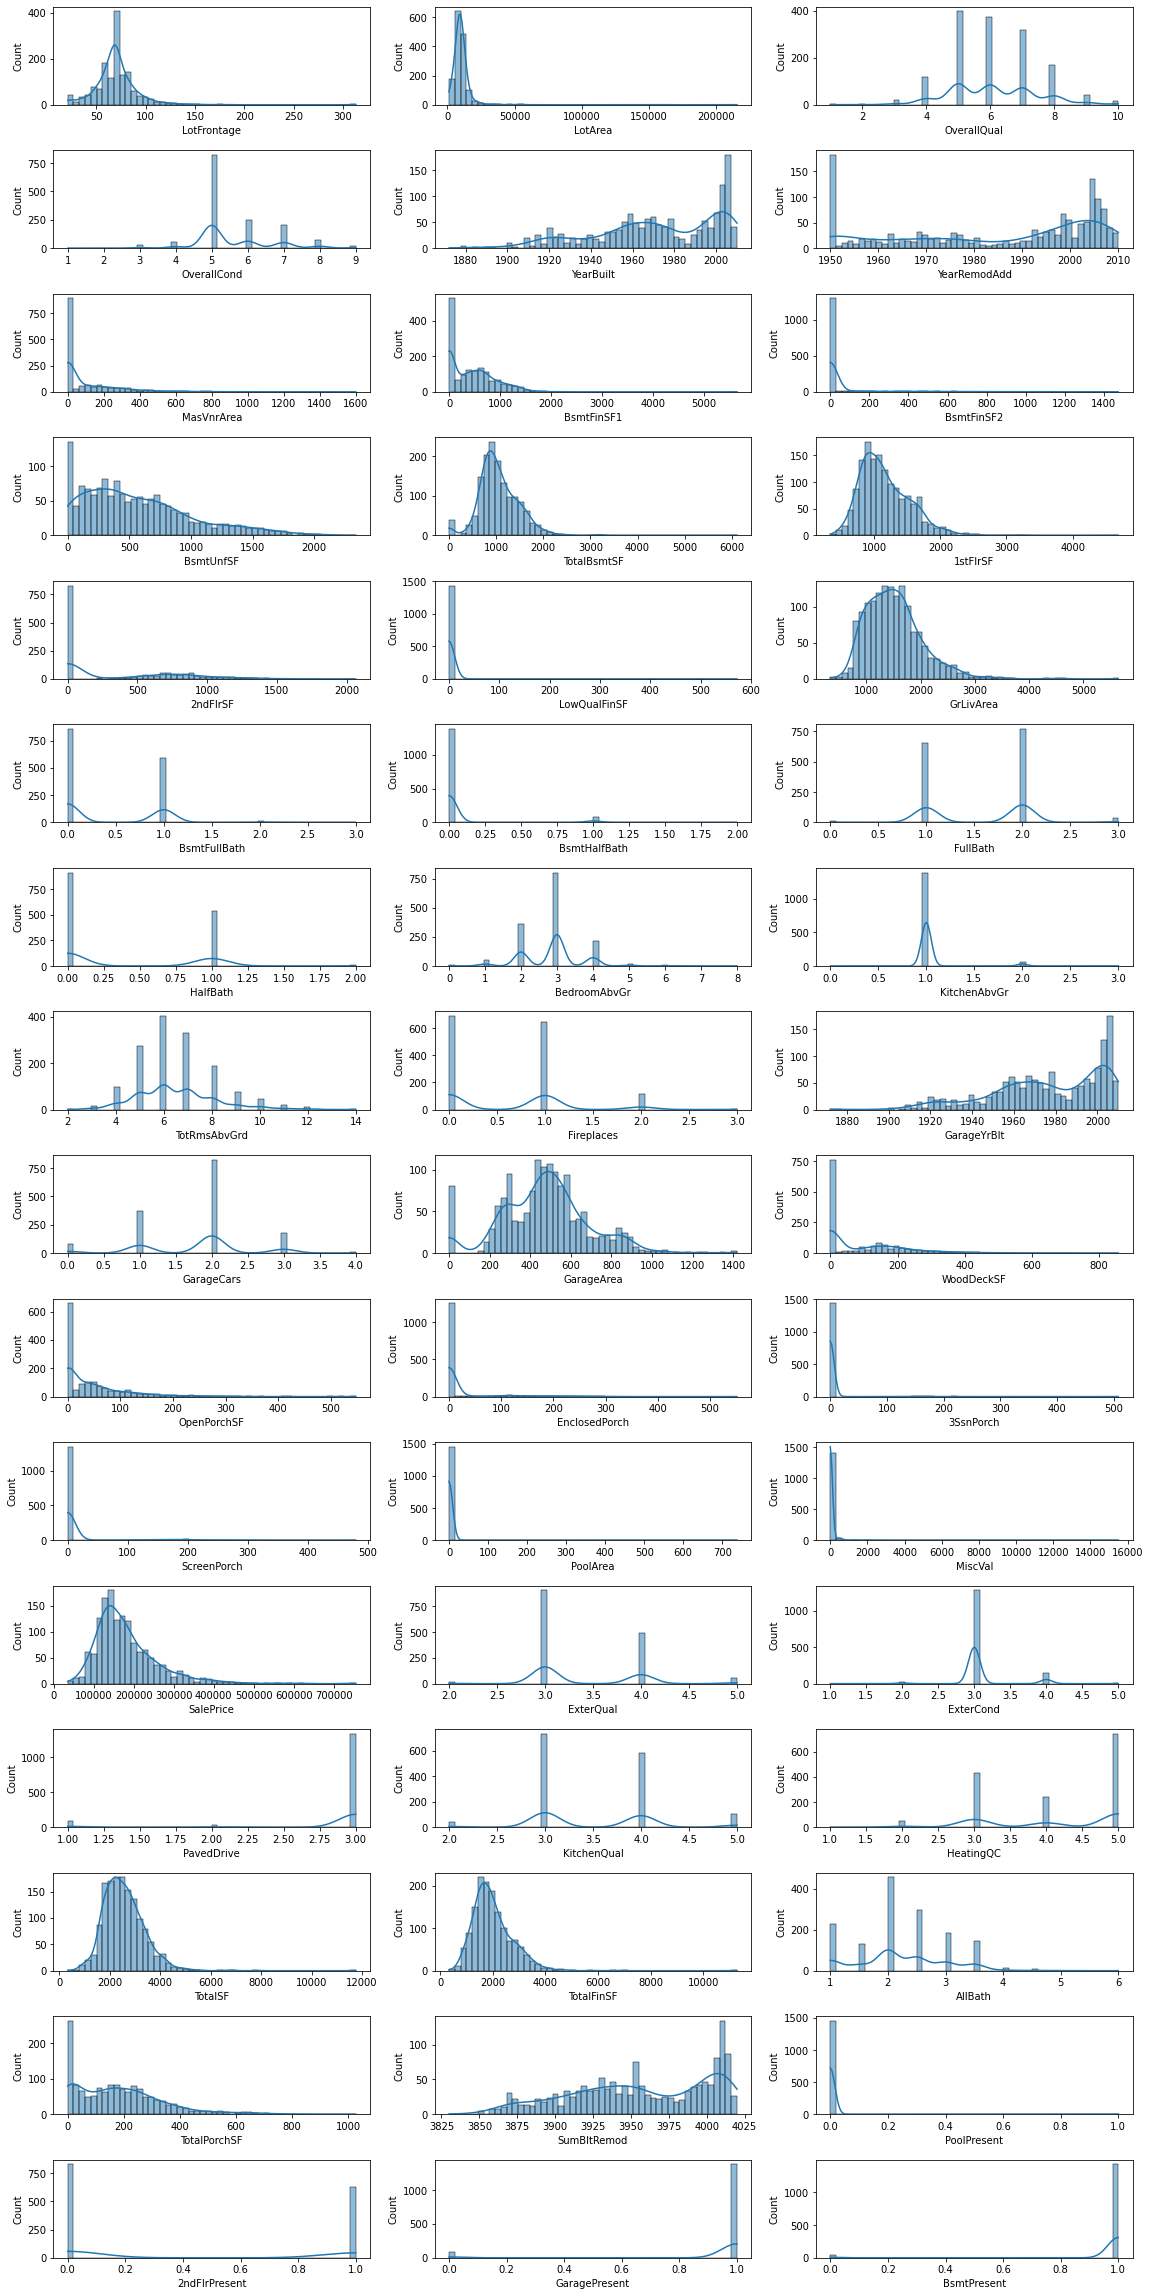

In [33]:
fig, axes = plt.subplots(round(len(cleaned_numerical_df.columns)/3), 3, figsize=(16,32))
for i, ax in enumerate(fig.axes):
    if i < len(cleaned_numerical_df.columns) - 1:
        sns.histplot(ax=ax, x=cleaned_numerical_df[cleaned_numerical_df.columns[i]], kde=True,  bins=50, edgecolor="black")
fig.tight_layout() 

In [34]:
skew_series = cleaned_numerical_df.drop(columns="SalePrice").apply(lambda x: skew(x)).sort_values(ascending=False)
skew_series.head(10)

MiscVal         24.451640
PoolArea        14.813135
PoolPresent     14.337930
LotArea         12.195142
3SsnPorch       10.293752
LowQualFinSF     9.002080
KitchenAbvGr     4.483784
BsmtFinSF2       4.250888
ScreenPorch      4.117977
BsmtHalfBath     4.099186
dtype: float64

### Made a list based on the figure above that would potentially benefit from skew adjustment. If variables had a higher than 0.75 skew value, they were boxcox transformed

In [40]:

skew_hist_list = ["LotFrontage", "LotArea", "YearBuilt","YearRemodAdd",
                  "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2","BsmtUnfSF",
                  "TotalBsmtSF", "1stFlrSF", "2ndFlrSF","LowQualFinSF",
                  "GrLivArea", "GarageArea", "WoodDeckSF","OpenPorchSF",
                  "EnclosedPorch", "3SsnPorch", "ScreenPorch","PoolArea",
                  "MiscVal", "TotalSF", "TotalFinSF","TotalPorchSF",
                  "SumBltRemod",      
                 ]
skew_series_list = skew_series[abs(skew_series) > 0.75].index
high_skew_list = [i for i in skew_hist_list if i in skew_series_list]

In [41]:
for skew_variable in high_skew_list:
    cleaned_numerical_df[skew_variable] = boxcox1p(cleaned_numerical_df[skew_variable],0.15)
    cleaned_numerical_df_test[skew_variable] = boxcox1p(cleaned_numerical_df_test[skew_variable],0.15)

In [42]:
cleaned_numerical_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,ExterQual,ExterCond,PavedDrive,KitchenQual,HeatingQC,TotalSF,TotalFinSF,AllBath,TotalPorchSF,SumBltRemod,PoolPresent,2ndFlrPresent,GaragePresent,BsmtPresent,FireplacePresent
0,1.280825,1.768158,7,5,2003,2003,1.416203,1.550724,0.0,1.385338,1.569352,1.569352,1.569128,0.0,1.633482,1,0,2,1,3,1,8,0,2003.0,2,548,0.000000,1.272322,0.000000,0.0,0.0,0.0,0.0,208500,4,3,3,4,5,1.669298,1.664059,3.5,1.272322,4006,0,1,1,1,0
1,1.308028,1.778257,6,8,1976,1976,0.000000,1.582027,0.0,1.457251,1.605834,1.605834,0.000000,0.0,1.605834,0,1,2,0,3,1,6,1,1976.0,2,460,1.462440,0.000000,0.000000,0.0,0.0,0.0,0.0,181500,3,3,3,3,5,1.667865,1.657443,2.5,1.462440,3952,0,0,1,1,1
2,1.286813,1.790694,7,5,2001,2002,1.394333,1.513540,0.0,1.501971,1.576232,1.576232,1.570463,0.0,1.637379,1,0,2,1,3,1,6,1,2001.0,2,608,0.000000,1.220496,0.000000,0.0,0.0,0.0,0.0,223500,4,3,3,4,5,1.673898,1.658687,3.5,1.220496,4003,0,1,1,1,1
3,1.270094,1.777845,7,5,1915,1970,0.000000,1.427145,0.0,1.524183,1.557382,1.580369,1.557382,0.0,1.633849,1,0,1,0,3,1,7,1,1998.0,3,642,0.000000,1.193938,1.452571,0.0,0.0,0.0,0.0,140000,3,3,3,4,4,1.666090,1.644430,2.0,1.465633,3885,0,1,1,1,1
4,1.314292,1.809054,8,5,2000,2000,1.479565,1.543375,0.0,1.514373,1.596816,1.596816,1.588986,0.0,1.655781,1,0,2,1,4,1,9,1,2000.0,3,836,1.413862,1.314292,0.000000,0.0,0.0,0.0,0.0,250000,4,3,3,4,5,1.692008,1.678458,3.5,1.454156,4000,0,1,1,1,1


## Investigating the correlation between numerical variables and the SalePrice:

In [43]:
correlation_matrix = cleaned_numerical_df.corr(method="spearman")
correlation_matrix_v2 = correlation_matrix.sort_values("SalePrice", ascending=False)
saleprice_correlation = correlation_matrix_v2["SalePrice"]
saleprice_correlation.head(10)

SalePrice      1.000000
TotalSF        0.819679
OverallQual    0.809829
GrLivArea      0.731310
TotalFinSF     0.707109
AllBath        0.703731
GarageCars     0.690711
ExterQual      0.684014
SumBltRemod    0.681351
KitchenQual    0.672849
Name: SalePrice, dtype: float64

### It was investigated if excluding variables with a lower correlation inproved the model. However, even excluding 1 variable resulted in a lower rmse. Therefore, the threshold below is set to 0 to include all numerical variables.

In [44]:
correlated_variables = saleprice_correlation[abs(saleprice_correlation) > 0].index
corr_numerical_df = cleaned_numerical_df[correlated_variables]
corr_numerical_df_test = cleaned_numerical_df_test[correlated_variables.drop("SalePrice")]

In [45]:
corr_numerical_df.describe()

,SalePrice,TotalSF,OverallQual,GrLivArea,TotalFinSF,AllBath,GarageCars,ExterQual,SumBltRemod,KitchenQual,YearBuilt,GarageArea,FullBath,GarageYrBlt,TotalBsmtSF,1stFlrSF,YearRemodAdd,TotRmsAbvGrd,FireplacePresent,Fireplaces,HeatingQC,OpenPorchSF,LotArea,TotalPorchSF,MasVnrArea,LotFrontage,WoodDeckSF,HalfBath,BsmtFinSF1,GaragePresent,2ndFlrSF,PavedDrive,BedroomAbvGr,BsmtFullBath,BsmtPresent,BsmtUnfSF,2ndFlrPresent,ScreenPorch,3SsnPorch,PoolArea,PoolPresent,ExterCond,BsmtHalfBath,BsmtFinSF2,MiscVal,LowQualFinSF,OverallCond,KitchenAbvGr,EnclosedPorch
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.00000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,180921.195890,1.664800,6.099315,1.617054,1.641023,2.210616,1.767123,3.39589,3956.133562,3.511644,1971.267808,472.980137,1.565068,1976.507534,1.544985,1.593045,1984.865753,6.517808,0.527397,0.613014,4.145205,0.702026,1.772915,1.152043,0.568274,1.282916,0.668258,0.382877,1.027623,0.944521,0.672732,2.856164,2.866438,0.425342,0.974658,1.383110,0.432192,0.111362,0.023098,0.007333,0.004795,3.083562,0.057534,0.167089,0.055081,0.025793,5.575342,1.046575,0.194876
std,79442.502883,0.027495,1.382997,0.030477,0.032585,0.785399,0.747315,0.57428,45.582882,0.663760,30.202904,213.804841,0.550916,26.306739,0.251505,0.029696,20.645407,1.625393,0.499420,0.644666,0.959501,0.638515,0.041277,0.536132,0.693033,0.043844,0.699245,0.502885,0.710171,0.228992,0.771722,0.496592,0.815778,0.518911,0.157217,0.419173,0.495550,0.379439,0.178957,0.105690,0.069100,0.351054,0.238753,0.466130,0.287137,0.191916,1.112799,0.220338,0.479105
min,34900.000000,1.474617,1.000000,1.474617,1.474617,1.000000,0.000000,2.00000,3830.000000,2.000000,1872.000000,0.000000,0.000000,1872.000000,0.000000,1.474617,1950.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.608567,0.000000,0.000000,1.114655,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,129975.000000,1.647872,5.000000,1.595546,1.621224,2.000000,1.000000,3.00000,3922.000000,3.000000,1954.000000,334.500000,1.000000,1959.000000,1.562337,1.572213,1967.000000,5.000000,0.000000,0.000000,3.000000,0.000000,1.759210,1.230327,0.000000,1.270094,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,2.000000,0.000000,1.000000,1.430708,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.000000
50%,163000.000000,1.666126,6.000000,1.619441,1.641171,2.000000,2.000000,3.00000,3955.000000,3.000000,1973.000000,480.000000,2.000000,1978.000000,1.583322,1.591964,1994.000000,6.000000,1.000000,1.000000,5.000000,1.142569,1.777253,1.395759,0.000000,1.288741,0.000000,0.000000,1.489154,1.000000,0.000000,3.000000,3.000000,0.000000,1.000000,1.511746,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.000000
75%,214000.000000,1.682886,7.000000,1.636914,1.662877,2.500000,2.000000,4.00000,4001.250000,4.000000,2000.000000,576.000000,2.000000,2001.000000,1.608443,1.614790,2004.000000,7.000000,1.000000,1.000000,5.000000,1.286813,1.793092,1.450142,1.395935,1.306405,1.398551,1.000000,1.551584,1.000000,1.553716,3.000000,3.000000,1.000000,1.000000,1.563810,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.000000
max,755000.000000,1.794095,10.000000,1.735608,1.790943,6.000000,4.000000,5.00000,4020.00

## Combining the numerical and categorical dataframes

In [46]:
selected_combined_df = pd.concat([corr_numerical_df, categorical_dummies],axis = 1)
selected_combined_df.head(1)

,SalePrice,TotalSF,OverallQual,GrLivArea,TotalFinSF,AllBath,GarageCars,ExterQual,SumBltRemod,KitchenQual,YearBuilt,GarageArea,FullBath,GarageYrBlt,TotalBsmtSF,1stFlrSF,YearRemodAdd,TotRmsAbvGrd,FireplacePresent,Fireplaces,HeatingQC,OpenPorchSF,LotArea,TotalPorchSF,MasVnrArea,LotFrontage,WoodDeckSF,HalfBath,BsmtFinSF1,GaragePresent,2ndFlrSF,PavedDrive,BedroomAbvGr,BsmtFullBath,BsmtPresent,BsmtUnfSF,2ndFlrPresent,ScreenPorch,3SsnPorch,PoolArea,PoolPresent,ExterCond,BsmtHalfBath,BsmtFinSF2,MiscVal,LowQualFinSF,OverallCond,KitchenAbvGr,EnclosedPorch,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofMatl_CompShg,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_Wall,CentralAir_N,CentralAir_Y,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NA,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,PoolQC_Ex,PoolQC_Gd,PoolQC_NA,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NA,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_NA,BsmtCond_Po,BsmtCond_TA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,MSSubClass_150
0,208500,1.669298,7,1.633482,1.664059,3.5,2,4,4006,4,2003,548,2,2003.0,1.569352,1.569352,2003,8,0,0,5,1.272322,1.768158,1.272322,1.416203,1.280825,0.0,1,1.550724,1,1.569128,3,3,1,1,1.385338,1,0.0,0.0,0.0,0,3,0,0.0,0.0,0.0,5,1,0.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0


In [47]:
selected_combined_df_test = pd.concat([corr_numerical_df_test, categorical_dummies_test],axis = 1)
selected_combined_df_test.head(1)

,TotalSF,OverallQual,GrLivArea,TotalFinSF,AllBath,GarageCars,ExterQual,SumBltRemod,KitchenQual,YearBuilt,GarageArea,FullBath,GarageYrBlt,TotalBsmtSF,1stFlrSF,YearRemodAdd,TotRmsAbvGrd,FireplacePresent,Fireplaces,HeatingQC,OpenPorchSF,LotArea,TotalPorchSF,MasVnrArea,LotFrontage,WoodDeckSF,HalfBath,BsmtFinSF1,GaragePresent,2ndFlrSF,PavedDrive,BedroomAbvGr,BsmtFullBath,BsmtPresent,BsmtUnfSF,2ndFlrPresent,ScreenPorch,3SsnPorch,PoolArea,PoolPresent,ExterCond,BsmtHalfBath,BsmtFinSF2,MiscVal,LowQualFinSF,OverallCond,KitchenAbvGr,EnclosedPorch,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofMatl_CompShg,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_Wall,CentralAir_N,CentralAir_Y,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NA,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,PoolQC_Ex,PoolQC_Gd,PoolQC_NA,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NA,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_NA,BsmtCond_Po,BsmtCond_TA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA
0,1.636977,5,1.573715,1.622132,1.0,1.0,3,3922,3,1961,730.0,1,1961.0,1.572213,1.573715,1961,5,0,0,3,0.0,1.793229,1.447652,0.0,1.308028,1.377192,0,1.509698,1,0.0,3,2,0.0,1,1.451768,0,1.358704,0.0,0.0,0,3,0.0,1.380528,0.0,0.0,6,1,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1


In [48]:
print(selected_combined_df.shape)
print(selected_combined_df_test.shape)

(1460, 197)
(1459, 196)


In [49]:
y = selected_combined_df["SalePrice"]
X = selected_combined_df.drop(columns="SalePrice")

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

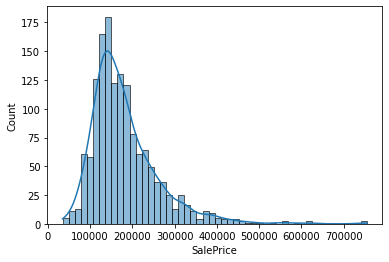

In [50]:
sns.histplot(x=y, kde=True, bins=50, edgecolor="black")

### The to be predicted variable SalePrice is skewed as well. Therefore SalePrice is also boxcox transformed:

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

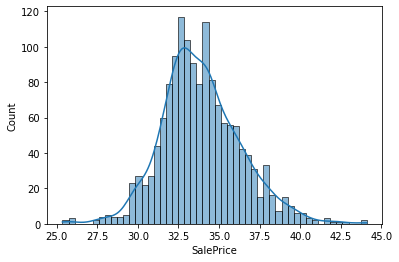

In [51]:
y_boxcox = boxcox1p(y,0.15)
sns.histplot(x=y_boxcox, kde=True, bins=50, edgecolor="black")

## Testing models:

In [52]:
def rmse_calc(test, pred):
    rmse = np.sqrt(metrics.mean_squared_error(test, pred))
    return rmse

In [53]:
RANDOM_STATE=42

In [54]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y_boxcox, test_size = 0.2,random_state=RANDOM_STATE)

In [55]:
# Define hyperparameters
xgb_parameters = {      "max_depth": [3],
                        "gamma":[0],
                        "subsample":[0.7],
                        "colsample_bytree":[0.7],
                        "scale_pos_weight":[1],
                        "colsample_bytree": [0.3],
                        "learning_rate": [0.01, 0.03, 0.05, 0.07],
                        "n_estimators": [2000, 3000, 4000 ,5000, 6000],
                        "reg_alpha":[0.00002,0.00004,0.00006,0.00008,0.00010]
                 }

# GridSearch
xgb_cv = GridSearchCV(estimator=xgb.XGBRegressor(),
                     param_grid=xgb_parameters,
                     n_jobs=-1,
                     verbose=1
                     )

# fit the GridSearch on train set
xgb_cv.fit(x_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {xgb_cv.best_params_}\n")
print(f"Best R²: {xgb_cv.best_score_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best hyperparameters: {'colsample_bytree': 0.3, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 6000, 'reg_alpha': 2e-05, 'scale_pos_weight': 1, 'subsample': 0.7}

Best R²: 0.9041811247208486


### XGB Regressor:

In [57]:
xgb_clf = xgb.XGBRegressor(learning_rate=0.01,
                                 n_estimators=6000,
                                 max_depth=3, min_child_weight=0,
                                 gamma=0, subsample=0.7,
                                 colsample_bytree=0.7,
                                 nthread=-1,
                                 scale_pos_weight=1, seed=RANDOM_STATE,
                                 reg_alpha=0.00002)
xgb_clf.fit(x_train, y_train)
xgb_y_pred = xgb_clf.predict(x_test)
rmse_calc(np.log(inv_boxcox1p(y_test,0.15)), np.log(inv_boxcox1p(xgb_y_pred,0.15)))
# Best RMSE: 0.11940922100749593

0.11940922100749593

### LassoCV:

In [58]:
lasso_clf = LassoCV(alphas=(1, 0.1, 0.001, 0.005),
                                         max_iter=50000,
                                         cv=5)
lasso_clf.fit(x_train, y_train)
lasso_y_pred = lasso_clf.predict(x_test)
rmse_calc(np.log(inv_boxcox1p(y_test,0.15)), np.log(inv_boxcox1p(lasso_y_pred,0.15)))
# Best RMSE: 0.12766026325984717

0.13682073508192566

### RidgeCV:

In [59]:
ridge_clf = RidgeCV(alphas=(10,1), cv=5)
ridge_clf.fit(x_train, y_train)
ridge_y_pred = ridge_clf.predict(x_test)
rmse_calc(np.log(inv_boxcox1p(y_test,0.15)), np.log(inv_boxcox1p(ridge_y_pred,0.15)))
# Best RMSE: 0.12695429502833697

0.14200023957308403

### ElasticNetCV:

In [60]:
elasticnet_clf = ElasticNetCV(alphas=(5, 1, 0.5, 0.1, 0.001, 0.005),
                                                   max_iter=50000,
                                                   cv=5)
elasticnet_clf.fit(x_train, y_train)
elasticnet_y_pred = elasticnet_clf.predict(x_test)
rmse_calc(np.log(inv_boxcox1p(y_test,0.15)), np.log(inv_boxcox1p(elasticnet_y_pred,0.15)))
# Best RMSE: 0.1272352151024142

0.1379649505783909

### RandomForest:

In [150]:
randomforestregressor_clf = RandomForestRegressor(n_estimators=1000,
                          max_depth=12,
                          random_state=RANDOM_STATE)
randomforestregressor_clf.fit(x_train, y_train)
randomforestregressor_y_pred = randomforestregressor_clf.predict(x_test)
rmse_calc(np.log(inv_boxcox1p(y_test,0.15)), np.log(inv_boxcox1p(randomforestregressor_y_pred,0.15)))
# Best RMSE: 0.14452824901769099

0.14448700258105326

### GradientBoosting:

In [64]:
gradientboostingregressor_clf = GradientBoostingRegressor(learning_rate=0.2,
                                                          n_estimators=500,
                                                          alpha=0.9,
                                                          random_state=RANDOM_STATE)

gradientboostingregressor_clf.fit(x_train, y_train)
gradientboostingregressor_y_pred = gradientboostingregressor_clf.predict(x_test)
rmse_calc(np.log(inv_boxcox1p(y_test,0.15)), np.log(inv_boxcox1p(gradientboostingregressor_y_pred,0.15)))
# Best RMSE: 0.1298593043688553

0.12986723861875624

### LGBM Regressor:

In [65]:
LGBMRegressor_clf = LGBMRegressor(objective="regression", 
                      num_leaves=4,
                      learning_rate=0.009, 
                      n_estimators=5000,
                      max_bin=200, 
                      bagging_fraction=0.8,
                      bagging_freq=5, 
                      feature_fraction=0.2,
                    random_state=RANDOM_STATE)
LGBMRegressor_clf.fit(x_train, y_train)
LGBMRegressor_y_pred = LGBMRegressor_clf.predict(x_test)

rmse_calc(np.log(inv_boxcox1p(y_test,0.15)), np.log(inv_boxcox1p(LGBMRegressor_y_pred,0.15)))
# Best RMSE: 0.12861810089001108

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


0.1305255394190712

### SVR:

In [66]:
SVR_clf  = make_pipeline(RobustScaler(), sklearn.svm.SVR(C= 20, epsilon= 0.008, gamma=0.0003))
SVR_clf.fit(x_train, y_train)
SVR_y_pred = SVR_clf.predict(x_test)
rmse_calc(np.log(inv_boxcox1p(y_test,0.15)), np.log(inv_boxcox1p(SVR_y_pred,0.15)))
# Best RMSE: 0.12868013763279193

0.12984707166951884

### Stacked model:

In [67]:
stack_clf = StackingCVRegressor(regressors=(xgb_clf, 
                                            gradientboostingregressor_clf, 
                                            LGBMRegressor_clf, 
                                            ridge_clf, 
                                            elasticnet_clf, 
                                            lasso_clf, 
                                            SVR_clf 
                                           ),
                                meta_regressor=xgb_clf,
                                use_features_in_secondary=True,
                                random_state=RANDOM_STATE
                               )

stack_clf.fit(np.array(x_train), np.array(y_train.values))
stack_y_pred = stack_clf.predict(np.array(x_test))
rmse_calc(np.log(inv_boxcox1p(y_test,0.15)), np.log(inv_boxcox1p(stack_y_pred,0.15)))
# Best RMSE: 0.12543242327149245

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

0.12691476867733237

### Blended model:

In [68]:
def blend_predict(X):
    return ((0.7 * xgb_clf.predict(X)) +
#             (0.05 * gradientboostingregressor_clf.predict(X)) +
#             (0.05 * LGBMRegressor_clf.predict(X)) +
            (0.05 * ridge_clf.predict(X)) +
            (0.05 * elasticnet_clf.predict(X))+
            (0.05 * lasso_clf.predict(X))+
            (0.05 * SVR_clf.predict(X)) +
            (0.1 * stack_clf.predict(np.array(X)))
           )
blend_y_pred = blend_predict(x_test)
rmse_calc(np.log(inv_boxcox1p(y_test,0.15)), np.log(inv_boxcox1p(blend_y_pred,0.15)))
# Best RMSE: 0.11843030207468772

0.11921862612244993

# Predict final test data:

### Train on full dataset:


In [69]:
xgb_clf.fit(X, y_boxcox)
gradientboostingregressor_clf.fit(X, y_boxcox)
LGBMRegressor_clf.fit(X, y_boxcox)
ridge_clf.fit(X, y_boxcox)
elasticnet_clf.fit(X, y_boxcox)
lasso_clf.fit(X, y_boxcox)
SVR_clf.fit(X, y_boxcox)
stack_clf.fit(np.array(X), np.array(y_boxcox))

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

StackingCVRegressor(meta_regressor=XGBRegressor(base_score=0.5,
                                                booster='gbtree',
                                                callbacks=None,
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=0.7,
                                                early_stopping_rounds=None,
                                                enable_categorical=False,
                                                eval_metric=None, gamma=0,
                                                gpu_id=-1,
                                                grow_policy='depthwise',
                                                importance_type=None,
                                                interaction_constraints='',
                                                learning_rate=0.01, max_bin=256,
               

### Make the final predictions:

In [70]:
y_full_test_pred = inv_boxcox1p(xgb_clf.predict(selected_combined_df_test),0.15)
y_full_test_pred.shape

(1459,)

In [71]:
df_predicted_final = pd.DataFrame({"Id": df_test["Id"] , "SalePrice": y_full_test_pred})
df_predicted_final.head(3)

,Id,SalePrice
0,1461,117299.007812
1,1462,154664.781250
2,1463,187543.046875


In [72]:
df_predicted_final.to_csv("predict_version17.csv", index = False)

### Note: The model is still overfitting on the train data. Thus, this model could possibly be improved (to increase the RMSE on the Kaggle leaderboard) by optimising cross-validation.